# NetPointLib
This notebook demonstrates an example use case of the NetPointLib.
The data used is the Chicago crime data points Feb 7-27 and the Chicago Road centerline obtained using the osmnx library.

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('../lib'))
if module_path not in sys.path:
    sys.path.append(module_path)


from map_matching import *
from hotspot import *

In [3]:
crimes = pd.read_csv("../data/Crimes_Chicago_last 30.csv")


In [4]:
xmin = crimes["Longitude"].min()
xmax = crimes["Longitude"].max()
ymin = crimes["Latitude"].min()
ymax = crimes["Latitude"].max()

In [5]:
prob = ((xmin+xmax)/2, (ymin+ymax)/2)

In [6]:
G = match_events_to_tile_cropped_by_place("Chicago", prob, crimes, show_log = True)

No. of events:  755
               x          y
56    -87.704842  41.837951
73    -87.720117  41.860067
118   -87.723109  41.836079
138   -87.705502  41.860520
145   -87.689307  41.807697
...          ...        ...
14249 -87.711236  41.854860
14252 -87.732913  41.854298
14322 -87.687617  41.812023
14343 -87.723572  41.807423
14361 -87.695361  41.848867

[755 rows x 2 columns]
Finding nearest edge for  -56 ,  x   -87.704842
y    41.837951
Name: 56, dtype: float64
Nearest edge is  (3239038829, 5492719997, 0)
Matched through pedal  -87.70484412464158 41.83795065457434
Finding nearest edge for  -73 ,  x   -87.720117
y    41.860067
Name: 73, dtype: float64
Nearest edge is  (4075414551, 261316079, 0)
Matched through pedal  -87.72010881064807 41.86006716569909
Finding nearest edge for  -118 ,  x   -87.723109
y    41.836079
Name: 118, dtype: float64
Nearest edge is  (261211677, 2428179940, 0)
Matched through interpolate  -87.7230858 41.8350906
Finding nearest edge for  -138 ,  x   -87.705502


To project the data points to the network, we specify the input city network by name and the csv file containing the data points. The x and y coordinates are the 'Longityde' colum and 'Latitude' colum. The number of cores available for CyberGIS-Jupyter is 10.

In [ ]:
G = match_points_to_network("Chicago", "../data/Crimes_Chicago_last 30.csv",  "Longitude", "Latitude", 10)

348  edges removed


In [7]:
count = 0
for e in G.edges:
    #print(G.edges[e])
    if 'event_count' in G.edges[e]:
        count += G.edges[e]['event_count']
        print(G.edges[e])
    #count += 1
    #if count > 10:
        #break
print(count)

{'osmid': 1209893273, 'name': 'West Pershing Road', 'highway': 'tertiary', 'oneway': False, 'reversed': False, 'length': 86.44, 'geometry': <LINESTRING (-87.69 41.823, -87.69 41.823, -87.691 41.823, -87.691 41.823, -...>, 'event_count': 1, 'event_dist_to_smaller_node': {-1681: 3411.2602923505333}, 'event_projected_coordinate': {-1681: (-87.6899494, 41.8228773)}}
{'length': 101.086, 'oneway': False, 'event_count': 1, 'event_dist_to_smaller_node': {-5570: 35.80549554733673}, 'event_projected_coordinate': {-5570: (-87.71854168882642, 41.862810671440506)}}
{'osmid': 24110600, 'name': 'West 47th Place', 'highway': 'residential', 'access': 'destination', 'oneway': False, 'reversed': True, 'length': 302.74500000000006, 'geometry': <LINESTRING (-87.711 41.807, -87.711 41.807, -87.708 41.807, -87.708 41.807)>, 'event_count': 1, 'event_dist_to_smaller_node': {-12026: 0}, 'event_projected_coordinate': {-12026: (-87.7076335, 41.8067668)}}
{'osmid': 797830638, 'name': 'West Pershing Road', 'highway

In [10]:
matched_points = []
for e in G.edges:
    if 'event_projected_coordinate' in G.edges[e]:
        matched_points.extend(list(G.edges[e]['event_projected_coordinate'].values()))
    

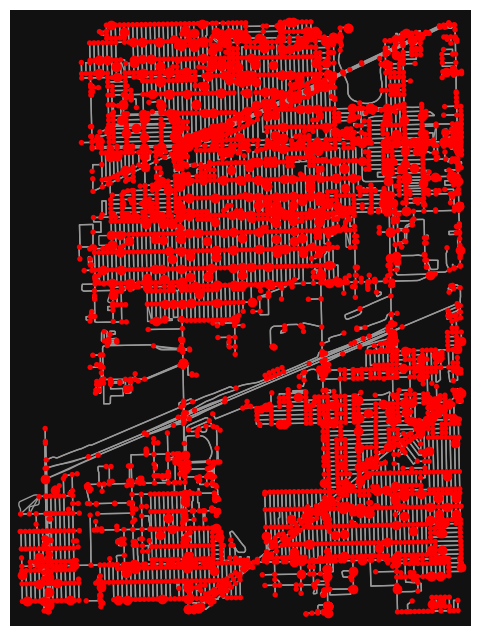

In [13]:
fig, ax = ox.plot_graph(G, node_color="r", show = False, close = False)
xylist = list(map(list, zip(*matched_points)))

ax.scatter(xylist[0], xylist[1], c='red')

In [1]:
matched_indices = []
for e in G.edges:
    if 'event_projected_coordinate' in G.edges[e]:
        matched_indices.extend(list(G.edges[e]['event_projected_coordinate']))
    

NameError: name 'G' is not defined

In [ ]:
fig, ax = ox.plot_graph(G, node_color="r", show = False, close = False)
xylist = list(map(list, zip(*matched_points)))

ax.scatter(xylist[0], xylist[1], c='red')

In [ ]:
for n in G.nodes:
    if n < 0:
        print(n)
        break

-201


The fused data set is visualized below with the data points highlighted in red.

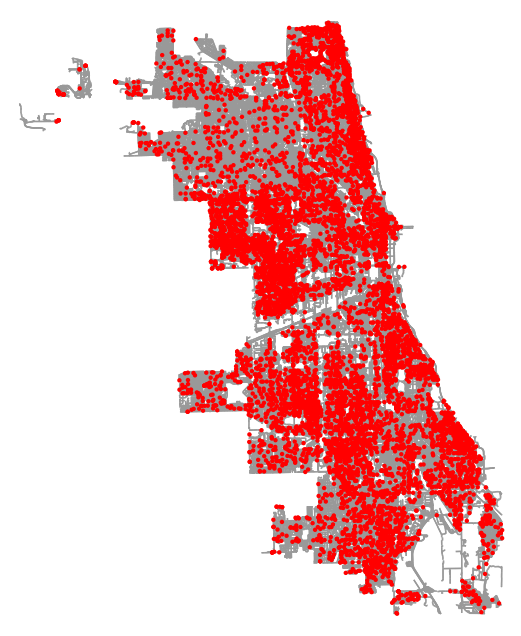

In [ ]:
nc = ["r" if (node <0) else "b" for node in G.nodes()]
ns = [10 if (node <0) else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size = ns, bgcolor = '#ffffff', save = False)

With the fused data, one of the example analysis we can perform is the network local auto k function. By default it set the radius of the subnetworks to be 1600 meters.

In [ ]:
from network_local_k import *
result_dict = {}
for node in G.nodes:
    result = network_local_k(node, G, wholeN(G), wholeL(G), show_log = False)
    result_dict[node] = result

All points who are centers of the subnetworks considered clusters by the k function with the 95% confidence level is highlighted in red below

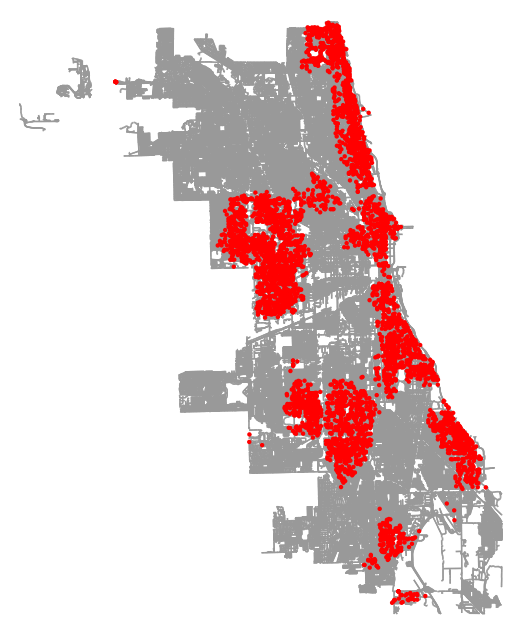

In [ ]:
nc = ["r" if (node < 0 and resultDic[node] > 0) else "b" for node in G.nodes()]
ns = [10 if (node < 0 and resultDic[node] > 0) else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size = ns, bgcolor = '#ffffff', save = False)

We then highlight the parts of the network that are hotspots (clustered) and coldspots (dispersed) in red and blue respectivelly:

In [ ]:
highlight_edges = set()
lowlight_edges = set()
for n in resultDic.keys():
    if resultDic[n] > 0:
        distances, paths = nx.single_source_dijkstra(G,n,cutoff=1600, weight = 'length') 
        for m in paths.keys():
            highlight_edges.update(list(G.edges(m)))
    if resultDic[n] < 0:
        distances, paths = nx.single_source_dijkstra(G,n,cutoff=1600, weight = 'length') 
        for m in paths.keys():
            lowlight_edges.update(list(G.edges(m)))

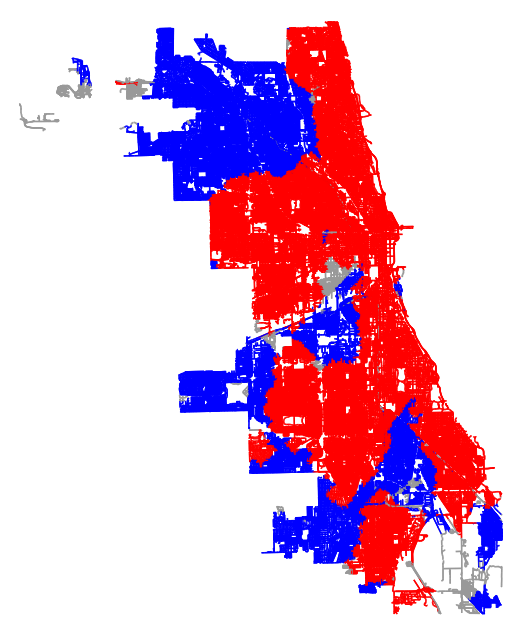

In [ ]:
ec = ["r" if edge in highlight_edges else "b" if edge in lowlight_edges else "#999999" for edge in G.edges()]
fig, ax = ox.plot_graph(G, node_color='b', node_size = 0, edge_color = ec, bgcolor = '#ffffff', save = False)